# Did you perceive the tinnitus right now? 
## Analysis grouped by country and continent

In [1]:
# project location
p_loc = 'C:/Users/joa24jm/Documents/tinnitus-country/'

# add src to path so the noteboook can import utilities.py
import sys
sys.path.append('C:\\Users\\joa24jm\\Documents\\tinnitus-country\\src\\')

In [2]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from d00_utils import utilities as u

In [3]:
# read in intermediate dataframe merged_users
df = pd.read_csv(p_loc + 'data/02_intermediate/merged_users.csv', index_col = 'Unnamed: 0')

In [4]:
# replace column names and values for better readability
df.rename(columns = {'question1': 'Tinnitus_right_now'}, inplace = True)
df.Tinnitus_right_now.replace({0.0:'No', 1.0:'Yes'}, inplace = True)

In [5]:
# generate a crosstab and save it as 'ct'
ct = pd.crosstab(df.Continent_Name, df.Tinnitus_right_now)
ct

Tinnitus_right_now,No,Yes
Continent_Name,,
Africa,105,371
Antarctica,2,0
Asia,638,2676
Europe,17462,58748
North America,1816,10505
Oceania,155,1526
South America,241,1180


In [6]:
# stack results and rename for better readability
stacked = ct.stack().reset_index().rename(columns={0:'value'})
stacked.Continent_Name.replace({'North America':'North\nAmerica', 'South America':'South\nAmerica'}, inplace = True)

In [7]:
stacked

,Continent_Name,Tinnitus_right_now,value
0,Africa,No,105
1,Africa,Yes,371
2,Antarctica,No,2
3,Antarctica,Yes,0
4,Asia,No,638
5,Asia,Yes,2676
6,Europe,No,17462
7,Europe,Yes,58748
8,North\nAmerica,No,1816
9,North\nAmerica,Yes,10505


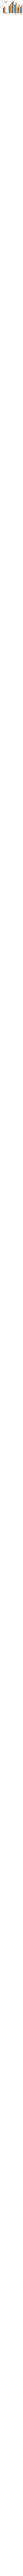

In [8]:
# create plot and add annotations
fig, ax = plt.subplots(1,1)

# remove top and right frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.barplot(x= stacked.Continent_Name, y = stacked.value, hue = stacked.Tinnitus_right_now, ax = ax)

# set log scale and labels
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('Count')

# show values on bars
u.show_values_on_bars(ax, h_v = 'v', space = 1)


## Plot tinnitus_right_now per country on a horizontal barplot

In [9]:
# generate a crosstab and save it as 'ct'
ct = pd.crosstab(df.Country_Name, df.Tinnitus_right_now)
# get the top 20 countries for tinnitus=YES
ct = ct.sort_values('Yes', ascending = False).iloc[:20,]

In [10]:
# stack results and rename for better readability
stacked = ct.stack().reset_index().rename(columns={0:'value'})
stacked

,Country_Name,Tinnitus_right_now,value
0,"Germany, Federal Republic of",No,10789
1,"Germany, Federal Republic of",Yes,40495
2,United States of America,No,1206
3,United States of America,Yes,8218
4,"Netherlands, Kingdom of the",No,2388
5,"Netherlands, Kingdom of the",Yes,4833
6,"Switzerland, Swiss Confederation",No,1677
7,"Switzerland, Swiss Confederation",Yes,3429
8,United Kingdom of Great Britain & Northern Ire...,No,755
9,United Kingdom of Great Britain & Northern Ire...,Yes,2919


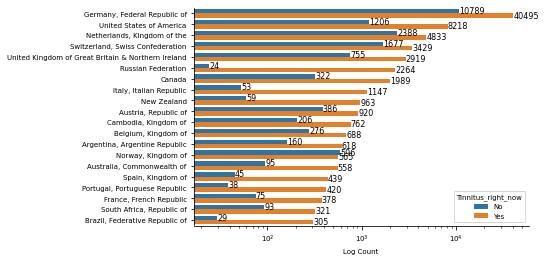

In [11]:
# decrease font size
matplotlib.rcParams.update({'font.size': 7})

# create plot and add annotations
fig, ax = plt.subplots(1,1)

# remove top and right frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.barplot(y= stacked.Country_Name, x = stacked.value, hue = stacked.Tinnitus_right_now, ax = ax,
            orient = 'h')

# set log scale and labels
ax.set_xscale('log')
ax.set_xlabel('Log Count')
ax.set_ylabel('')

# show values on bars
u.show_values_on_bars(ax, h_v = 'h', space = 0.4)

# safe ylabels as reference for normalized bar plot
ylabels = [label.get_text() for label in ax.get_yticklabels()]


In [12]:
# generate a crosstab and save it as 'ct'
ct = pd.crosstab(df.Country_Name, df.Tinnitus_right_now, normalize = 'index')
# get the top 20 countries for tinnitus=YES
ct = ct.loc[ylabels,]

In [13]:
# stack results and rename for better readability
stacked = ct.stack().reset_index().rename(columns={0:'value'})

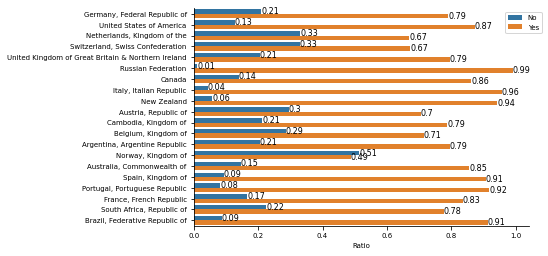

In [14]:
# decrease font size
matplotlib.rcParams.update({'font.size': 7})

# create plot and add annotations
fig, ax = plt.subplots(1,1)

# remove top and right frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.barplot(y= stacked.Country_Name, x = stacked.value, hue = stacked.Tinnitus_right_now, ax = ax,
            orient = 'h')

# set log scale and labels
ax.set_xlabel('Ratio')
ax.set_ylabel('')

ax.legend(bbox_to_anchor=(1.05,1))

# show values on bars
u.show_values_on_bars(ax, h_v = 'h', space = 0.4, normalize = True)

# safe ylabels as reference for normalized bar plot
ylabels = [label.get_text() for label in ax.get_yticklabels()]